# elec_consumption

Clustering and regression for household power consumption profiles.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#hide
from elec_consumption.utils import ContextTimer
import datetime
from loguru import logger
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.core.frame import DataFrame
import seaborn as sns

In [ ]:
#hide
%matplotlib inline
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [6 * 1.61803398875, 6]
_seed = 123  # for clustering analysis
data = {}  # contain modified dataframes

In [ ]:
#hide
df = pd.read_csv('./data/raw.csv', index_col=0)
df.columns = list(range(df.shape[1]))
df.columns.name = 'household'
df.index = pd.to_datetime(df.index)
df.index.name = 'datetime'

## 1. Introduction

There are 500 power consumption profiles from 500 households (units) spanning 122 days (Aug 1, 2017 to Nov 30, 2017).

First five observations of first five households are previewed. Physical unit of entries is not mentioned in the data set, and is presumed to be kiloWatt (kW). The physical unit only matters in interpretation because forecasted values are more or less the same.

In [ ]:
#hide_input
df.iloc[:5, :5]

household,0,1,2,3,4
datetime,,,,,
2017-08-01 00:00:00,0.094,0.028,0.116,0.096,0.189
2017-08-01 00:30:00,0.039,0.050,0.068,0.077,0.156
2017-08-01 01:00:00,0.088,0.060,0.044,0.095,0.118
2017-08-01 01:30:00,0.046,0.023,0.067,0.092,0.145
2017-08-01 02:00:00,0.082,0.020,0.068,0.085,0.153


Power consumption profiles of household 0, 1, 2 on Aug 1, 2017 are plotted:

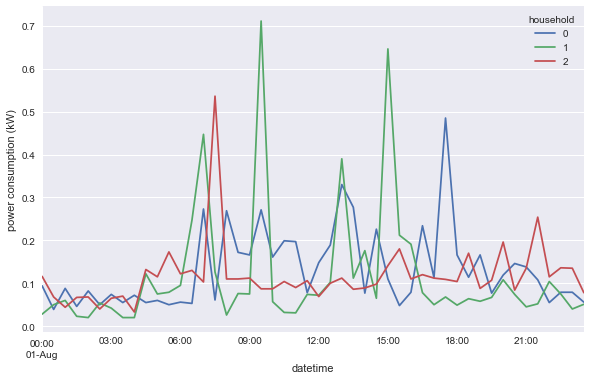

In [ ]:
#hide_input
df[df.index.date == datetime.date(2017, 8, 1)].iloc[:, :3].plot(
    ylabel='power consumption (kW)'
);

Here is the hourly down-sampled averaged profile of 0 on Aug 1, 2017. It is compared to the original profile.

In [ ]:
#hide
df_hour_0 = (
    df[df.index.date == datetime.date(2017, 8, 1)].loc[:, 0]
    .resample('1H', closed='left').mean().to_frame()
)
df_hour_0.columns = ['power']
df_hour_0['freq'] = 'hour'
df_hour_0.reset_index(inplace=True)
df_hour_0.set_index(['datetime', 'freq'], inplace=True)

In [ ]:
#hide
df_halfhour_0 = df[df.index.date == datetime.date(2017, 8, 1)].loc[:, 0].to_frame()
df_halfhour_0.columns = ['power']
df_halfhour_0['freq'] = 'half-hour'
df_halfhour_0.reset_index(inplace=True)
df_halfhour_0.set_index(['datetime', 'freq'], inplace=True)

In [ ]:
#hide
df_0 = pd.concat([df_hour_0, df_halfhour_0])

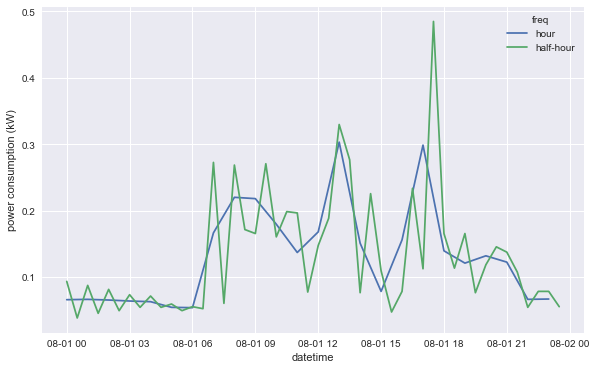

In [ ]:
#hide_input
ax = sns.lineplot(data=df_0, y='power', x='datetime', hue='freq')
ax.set(ylabel='power consumption (kW)');

## 2. Daily Down-Sampled Averaged Profiles

Here are daily down-sampled averaged profiles of households 0 and 1 for the whole period. There are some days when there is no entries. Such missing entries are discussed in the following section.

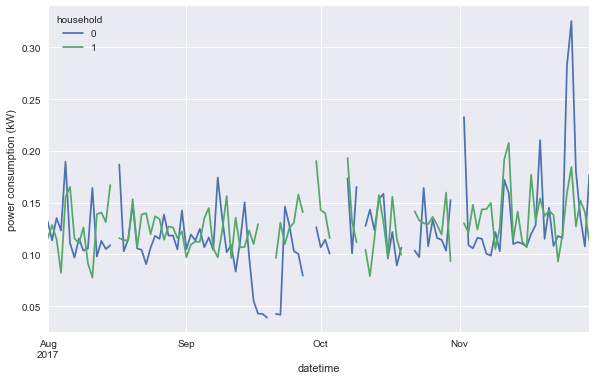

In [ ]:
#hide_input
df_daily = df.iloc[:, :2].resample('1D', closed='left').mean()
df_daily.plot(ylabel='power consumption (kW)');

Entries in Aug, 2017 are zoomed in.

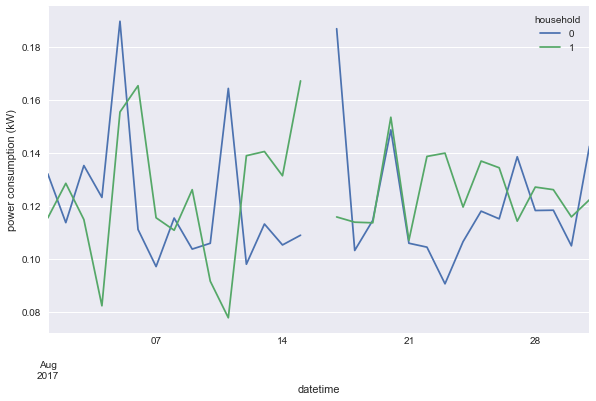

In [ ]:
#hide_input
df_daily[
    df_daily.index.date <= datetime.date(2017, 8, 31)
].plot(ylabel='power consumption (kW)');

## 3. Handle Missing Entries

The distribution of missing entries can be summarised as:

- For households 162, 428 and 432, two entries in different sets of dates are missed".
- For all the other households, 48 entries in different sets of dates are missed.
- There are only 186 time points when data is complete.

In [ ]:
#hide
_dates_two_nan_somedays = {162, 428, 432}

In [ ]:
#hide
# There are only 186 rows having complete data.
assert df.dropna(axis=0).shape[0] == 186

In [ ]:
#hide
def filt_dates_missing(df: DataFrame, household: int) -> DataFrame:
    """Find num of missing entries for every day.

    Args:
        df: original dataframe.
        household: integer index of given household.

    Return:
        Num of NaN per day.
    """
    num_nan_daily = (
        df.iloc[:, household].groupby(df.index.date)
        .apply(lambda x: x.isna().values.sum()).to_frame()
    )
    num_nan_daily.columns = ['num_nan_daily']
    return num_nan_daily[num_nan_daily['num_nan_daily'] > 0]

In [ ]:
#hide
def filt_dates_missing_set(df: DataFrame, household: int) -> set:
    """Find missing days in series of `household`.

    Args:
        df: original dataframe.
        household: integer index of given household.

    Return:
        Dates when all entries are missing.
    """
    if household in _dates_two_nan_somedays:
        logger.warning(
            f'Household {household} misses two entries sometimes'
        )
    return set(filt_dates_missing(df, household).index)

In [ ]:
#hide
assert filt_dates_missing_set(df, 0).symmetric_difference(
    filt_dates_missing_set(df, 1)
) == {datetime.date(2017, 9, 18)}

In [ ]:
#hide
with ContextTimer():
    res = {}
    num_household = 15
    for h in range(num_household - 1):
        for j in range(h+1, num_household):
            diff = filt_dates_missing_set(df, h).symmetric_difference(
                filt_dates_missing_set(df, j)
            )
            res[(h, j)] = len(diff)

It took 5.323572874069214 seconds to run.


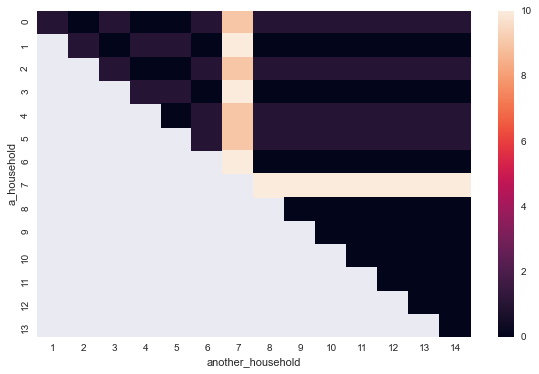

In [ ]:
#hide
df_dates = pd.DataFrame.from_dict(res, orient='index')
df_dates.index = pd.MultiIndex.from_tuples(df_dates.index)
df_dates.columns = ['difference']
df_dates.index.names = ['a_household', 'another_household']

# Untack to build a matrix.
df_dates = df_dates.unstack()
df_dates.columns = df_dates.columns.get_level_values(1)

# ~~It seems that two sets of missing days corresponding to any
# pair of households (except 162, 428, 432) are differentiated
# by 1 dates.~~
sns.heatmap(df_dates);

Linear interpolation is not very useful. For example, how entries Aug 16, 2017 for household 0 are filled can be plotted. Such interpolation can distored both clustering and regression results.

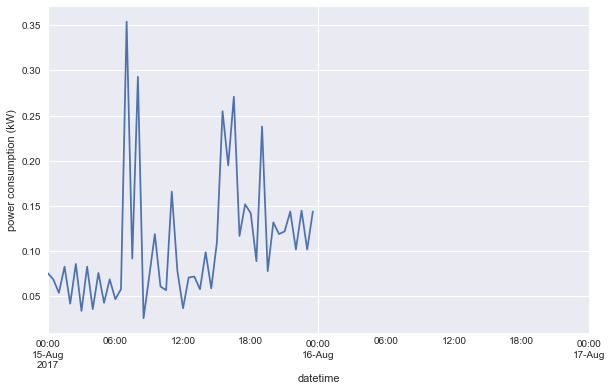

In [ ]:
#hide
df.loc[
    datetime.date(2017, 8, 15):datetime.date(2017, 8, 17), 0
].plot(ylabel='power consumption (kW)');

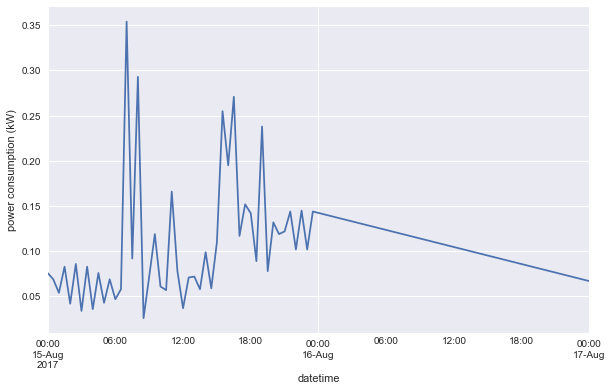

In [ ]:
#hide_input
df.loc[
    datetime.date(2017, 8, 15):datetime.date(2017, 8, 17), 0
].interpolate(method='linear').plot(ylabel='power consumption (kW)');